# Variational Auto Encoder
This notebook demonstrates the training of a Variational Autoencoder (VAE) to learn transformations from input climate data to corresponding forced responses.

In [1]:
# Import necessary libraries
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings


from torch.utils.data import DataLoader

# Add utility paths
sys.path.append(os.path.join(os.getcwd(), 'utils'))

# Import utility functions
from utils.data_loading import *
from utils.data_processing import *
from utils.vae import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# Enable autoreload
%reload_ext autoreload
%autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define data path
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Use MPS / Cuda or CPU if none of the options are available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
random.seed(42)

Using device: mps


In [3]:
# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl
Data loaded successfully.
Filtering data...
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 35662.48it/s]


Data filtered. Kept 34 models
Creating NaN mask...


100%|██████████| 34/34 [00:02<00:00, 14.42it/s]


NaN mask created.
Masking out NaN values...


100%|██████████| 34/34 [00:01<00:00, 26.67it/s]


NaN values masked out.
Reshaping data...


100%|██████████| 34/34 [00:04<00:00,  8.18it/s]


Data reshaped.
Adding the forced response to the data...


100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Forced response added.
Removing NaN values from the grid...


100%|██████████| 34/34 [00:03<00:00,  9.54it/s]


NaN values removed.


In [4]:
# Randomly select and keep the data corresponding to n models
n = 5
model_keys = random.sample(data.keys(), n)
data = {key: value for key,value in data.items() if key in model_keys}

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_82298/3740862327.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  model_keys = random.sample(data.keys(), n)


In [5]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data.keys()))
train_models = [model for model in data.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data[model] for model in train_models}
test_data = {test_model: data[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['EC-Earth3', 'E3SM-2-0', 'GISS-E2-1-G', 'ACCESS-ESM1-5']
Testing model: GISS-E2-2-G


In [6]:
center = True
normalized_train_data, normalized_test_data, _, _ = normalize_data(train_data, test_data, center=center)


Normalizing data...


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 26.12it/s]

Data normalization completed.


Flattened the data


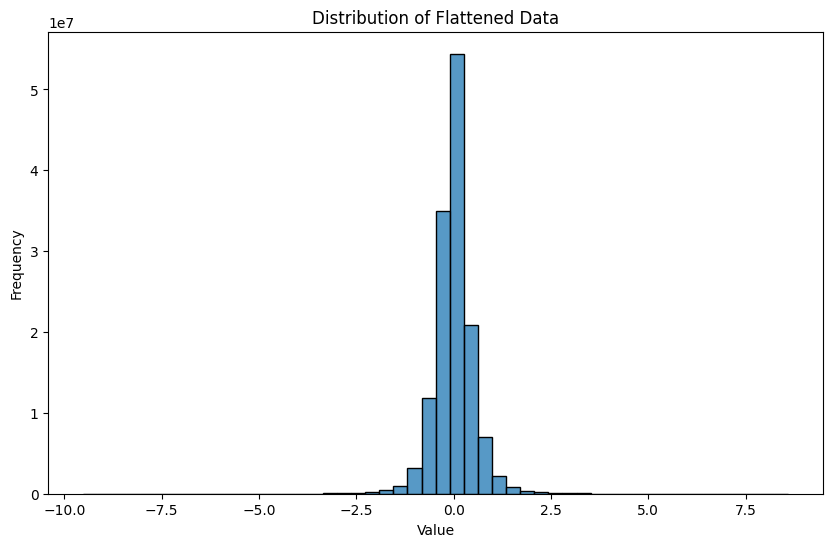

In [7]:
# Print the distribution of the data
# Flatten the data for analysis
flattened_data = np.concatenate([np.ravel(array) for model in normalized_train_data.values() for array in model.values()])
print("Flattened the data")
# Plot the distribution of the data
plt.figure(figsize=(10, 6))
sns.histplot(flattened_data, bins=50, kde=False)
plt.title('Distribution of Flattened Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

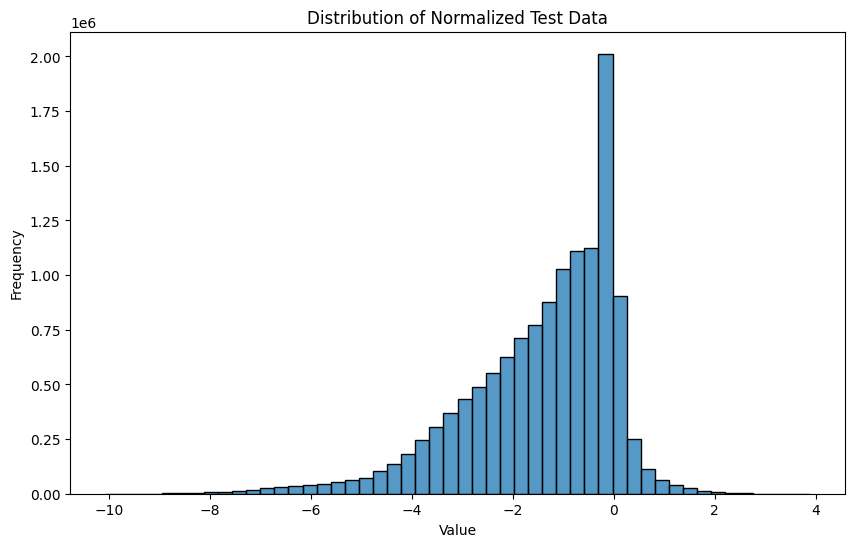

In [8]:
# Flatten the normalized_test_data for analysis
flattened_test_data = np.concatenate([np.ravel(array) for model in normalized_test_data.values() for array in model.values()])

# Plot the distribution of the flattened normalized_test_data
plt.figure(figsize=(10, 6))
sns.histplot(flattened_test_data, bins=50, kde=False)
plt.title('Distribution of Normalized Test Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Create dataset
train_dataset = ClimateDataset(normalized_train_data)
test_dataset = ClimateDataset(normalized_test_data)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Creating datasets...


Processing models: 100%|██████████| 4/4 [00:00<00:00, 86480.49it/s]
/Users/lharriso/Documents/GitHub/gm4cs-l/utils/vae.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(self.inputs, dtype=torch.float32)
/Users/lharriso/Documents/GitHub/gm4cs-l/utils/vae.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(self.inputs, dtype=torch.float32)


Creating datasets...


Processing models: 100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]



Training dataset size: 124
Testing dataset size: 11


In [10]:
# Initialize the VAE model
input_dim = train_dataset.inputs.shape[1] * train_dataset.inputs.shape[2]  # Flattened input dimensions
latent_dim = 50  # Reduced from 100
hidden_dim = 25  # Reduced from 50
mu_var_dim = 5  # Reduced from 10
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
vae_model = VAE(input_dim=input_dim, hidden_dim = hidden_dim, latent_dim=latent_dim, device=device, mu_var_dim=mu_var_dim).to(device)

# Apply weight initialization
vae_model.apply(initialize_weights)

# Define optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-4)  # Lower learning rate and add weight decay (was 1e-5)

# Train the VAE and collect loss values
losses = train_vae(vae_model, train_loader, optimizer, epochs=1000, device=device)

Using device: mps


  0%|          | 1/1000 [00:01<18:38,  1.12s/it]

Epoch 1, Average Loss: 743923.7964


 10%|█         | 101/1000 [01:18<11:27,  1.31it/s]

Epoch 101, Average Loss: 462728.7117


 20%|██        | 201/1000 [02:36<10:16,  1.30it/s]

Epoch 201, Average Loss: 337869.6452


 30%|███       | 301/1000 [03:53<09:06,  1.28it/s]

Epoch 301, Average Loss: 324600.2762


 40%|████      | 401/1000 [05:09<07:42,  1.30it/s]

Epoch 401, Average Loss: 323801.5343


 50%|█████     | 501/1000 [06:25<06:18,  1.32it/s]

Epoch 501, Average Loss: 323731.8700


 60%|██████    | 601/1000 [07:42<05:14,  1.27it/s]

Epoch 601, Average Loss: 323609.1804


 70%|███████   | 701/1000 [08:59<03:45,  1.32it/s]

Epoch 701, Average Loss: 323530.4476


 80%|████████  | 801/1000 [10:15<02:35,  1.28it/s]

Epoch 801, Average Loss: 323772.8065


 90%|█████████ | 901/1000 [11:30<01:18,  1.27it/s]

Epoch 901, Average Loss: 323436.0847


100%|██████████| 1000/1000 [12:46<00:00,  1.30it/s]



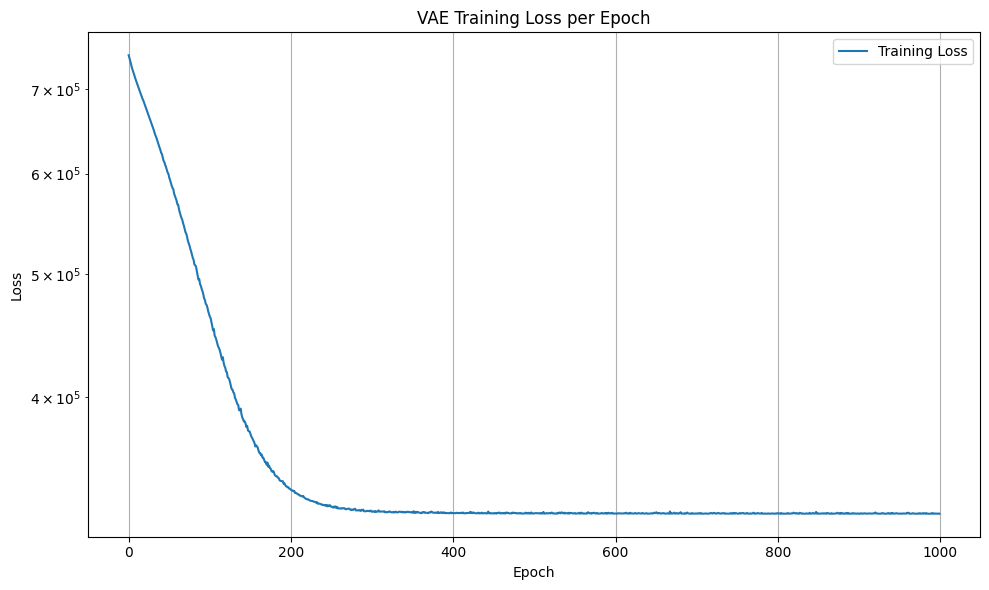

Final loss value: 3.23e+05


In [20]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.legend()
plt.title('VAE Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.yscale('log')  # Using log scale if loss values vary greatly
plt.tight_layout()
plt.show()

# Print the final loss value
print(f"Final loss value: {losses[-1]:.2e}")

# Save the loss values for future reference
# loss_dict = {'epochs': list(range(1, len(losses)+1)), 'loss_values': losses}
# with open('vae_training_losses.pkl', 'wb') as f:
#     pkl.dump(loss_dict, f)

In [25]:
# Evaluate VAE and generate animations
vae_model.eval()  # Set the model to evaluation mode
test_loss = 0
all_inputs = []
all_outputs = []
all_reconstructed = []

with torch.no_grad():  # Disable gradient computation for inference
    for batch in test_loader:
        # Access dictionary keys separately and move to device
        inputs = batch['input'].view(batch['input'].size(0), -1).to(device)  # Flatten input and move to device
        outputs = batch['output'].view(batch['output'].size(0), -1).to(device)  # Flatten output and move to device

        reconstructed, _, _ = vae_model(inputs)  # Forward pass through the VAE

        loss = torch.nn.functional.mse_loss(reconstructed, outputs, reduction='sum')  # Compute reconstruction loss
        test_loss += loss.item()
        
        # Store data for visualization (move back to CPU)
        all_inputs.extend(inputs.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())
        all_reconstructed.extend(reconstructed.cpu().numpy())

# Compute the average test loss
test_loss /= len(test_loader.dataset)
print(f"Average test loss: {test_loss:.2e}")

Average test loss: 1.00e+06


In [39]:
vae_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for _, batch in enumerate(test_loader):
        print(batch['input'].shape)

torch.Size([8, 165, 6523])
torch.Size([3, 165, 6523])


In [35]:
len(test_dataset)

11